In [1]:
# Downloading pretrained data and unzipping it
!gdown https://drive.google.com/uc?id=1_aDScOvBeBLCn_iv0oxSO8X1ySQpSbIS
# https://drive.google.com/uc?id=1_aDScOvBeBLCn_iv0oxSO8X1ySQpSbIS
!unzip modelNweight.zip

Downloading...
From: https://drive.google.com/uc?id=1_aDScOvBeBLCn_iv0oxSO8X1ySQpSbIS
To: /content/modelNweight.zip
100% 86.2M/86.2M [00:00<00:00, 170MB/s]
Archive:  modelNweight.zip
   creating: modelNweight/
  inflating: modelNweight/age_deploy.prototxt  
  inflating: modelNweight/age_net.caffemodel  
  inflating: modelNweight/gender_deploy.prototxt  
  inflating: modelNweight/gender_net.caffemodel  
  inflating: modelNweight/opencv_face_detector.pbtxt  
  inflating: modelNweight/opencv_face_detector_uint8.pb  


In [21]:
# Import required modules
import cv2 
import os
import math
import time
import argparse
from google.colab.patches import cv2_imshow
# import argparse

def getFaceBox(net, frame, confidence_threshold=0.7):
    frameOpencvDnn = frame.copy()
    print(frameOpencvDnn.shape)
    frameHeight = frameOpencvDnn.shape[0]
    frameWidth = frameOpencvDnn.shape[1]
    blob = cv2.dnn.blobFromImage(frameOpencvDnn, 1.0, (227, 227), [124.96,115.97,106.13], swapRB=True,crop=False)

    net.setInput(blob)
    detections = net.forward()
    bboxes = []
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > confidence_threshold:
            x1 = int(detections[0, 0, i, 3] * frameWidth)
            y1 = int(detections[0, 0, i, 4] * frameHeight)
            x2 = int(detections[0, 0, i, 5] * frameWidth)
            y2 = int(detections[0, 0, i, 6] * frameHeight)
            bboxes.append([x1, y1, x2, y2])
            cv2.rectangle(frameOpencvDnn, (x1, y1), (x2, y2), (0, 255, 0), int(round(frameHeight/150)), 8)
    return frameOpencvDnn, bboxes
#calling the pretrained models
faceProto = "modelNweight/opencv_face_detector.pbtxt"
faceModel = "modelNweight/opencv_face_detector_uint8.pb"
ageProto = "modelNweight/age_deploy.prototxt"
ageModel = "modelNweight/age_net.caffemodel"
genderProto = "modelNweight/gender_deploy.prototxt"
genderModel = "modelNweight/gender_net.caffemodel"

#MODEL_MEAN_VALUES = (78.4263377603, 87.7689143744, 114.895847746)
ageList = ['(0-2)', '(4-6)', '(8-12)', '(15-20)', '(25-32)', '(38-43)', '(48-53)', '(60-100)']
genderList = ['Male', 'Female']

# Loading in the neural network
ageNet = cv2.dnn.readNet(ageModel, ageProto)
genderNet = cv2.dnn.readNet(genderModel, genderProto)
faceNet = cv2.dnn.readNet(faceModel, faceProto)


#padding = 20
#live video capturing

video=cv2.VideoCapture(0)    # 0 - inbuilt webcam it will take & 1 - External camera
padding=20
while cv2.waitKey(1)<0:     # waitkey - video is running and capturing don't close
    hasFrame,frame=video.read()   
    if not hasFrame:              # if not frame is there
        cv2.waitKey()
        break
        
    resultImg,faceBoxes=detectFace(faceNet,frame)
    
    if not faceBoxes:            # if not any facebox is detecting
        print("No face detected")

def age_gender_detector(frame):
    # Read frame
    t = time.time()
    frameFace, bboxes = getFaceBox(faceNet, frame)
    for bbox in bboxes:
        # print(bbox)
        face = frame[max(0,bbox[1]-padding):min(bbox[3]+padding,frame.shape[0]-1),max(0,bbox[0]-padding):min(bbox[2]+padding, frame.shape[1]-1)]

        blob = cv2.dnn.blobFromImage(face, 1.0, (227, 227), MODEL_MEAN_VALUES, swapRB=False)
        genderNet.setInput(blob)
        genderPreds = genderNet.forward()
        gender = genderList[genderPreds[0].argmax()]
        # print("Gender Output : {}".format(genderPreds))
        print("Gender : {}, conf = {:.3f}".format(gender, genderPreds[0].max()))

        ageNet.setInput(blob)
        agePreds = ageNet.forward()
        age = ageList[agePreds[0].argmax()]
        print("Age Output : {}".format(agePreds))
        print("Age : {}, conf = {:.3f}".format(age, agePreds[0].max()))

        label = "{},{}".format(gender, age)
        cv2.putText(frameFace, label, (bbox[0], bbox[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2, cv2.LINE_AA)
    return frameFace

(1600, 1200, 3)
Gender : Male, conf = 1.000
Age Output : [[8.8093457e-06 5.8606087e-04 9.7224426e-01 3.1018469e-03 2.0188829e-02
  2.4684416e-03 1.3710839e-03 3.0650808e-05]]
Age : (8-12), conf = 0.972


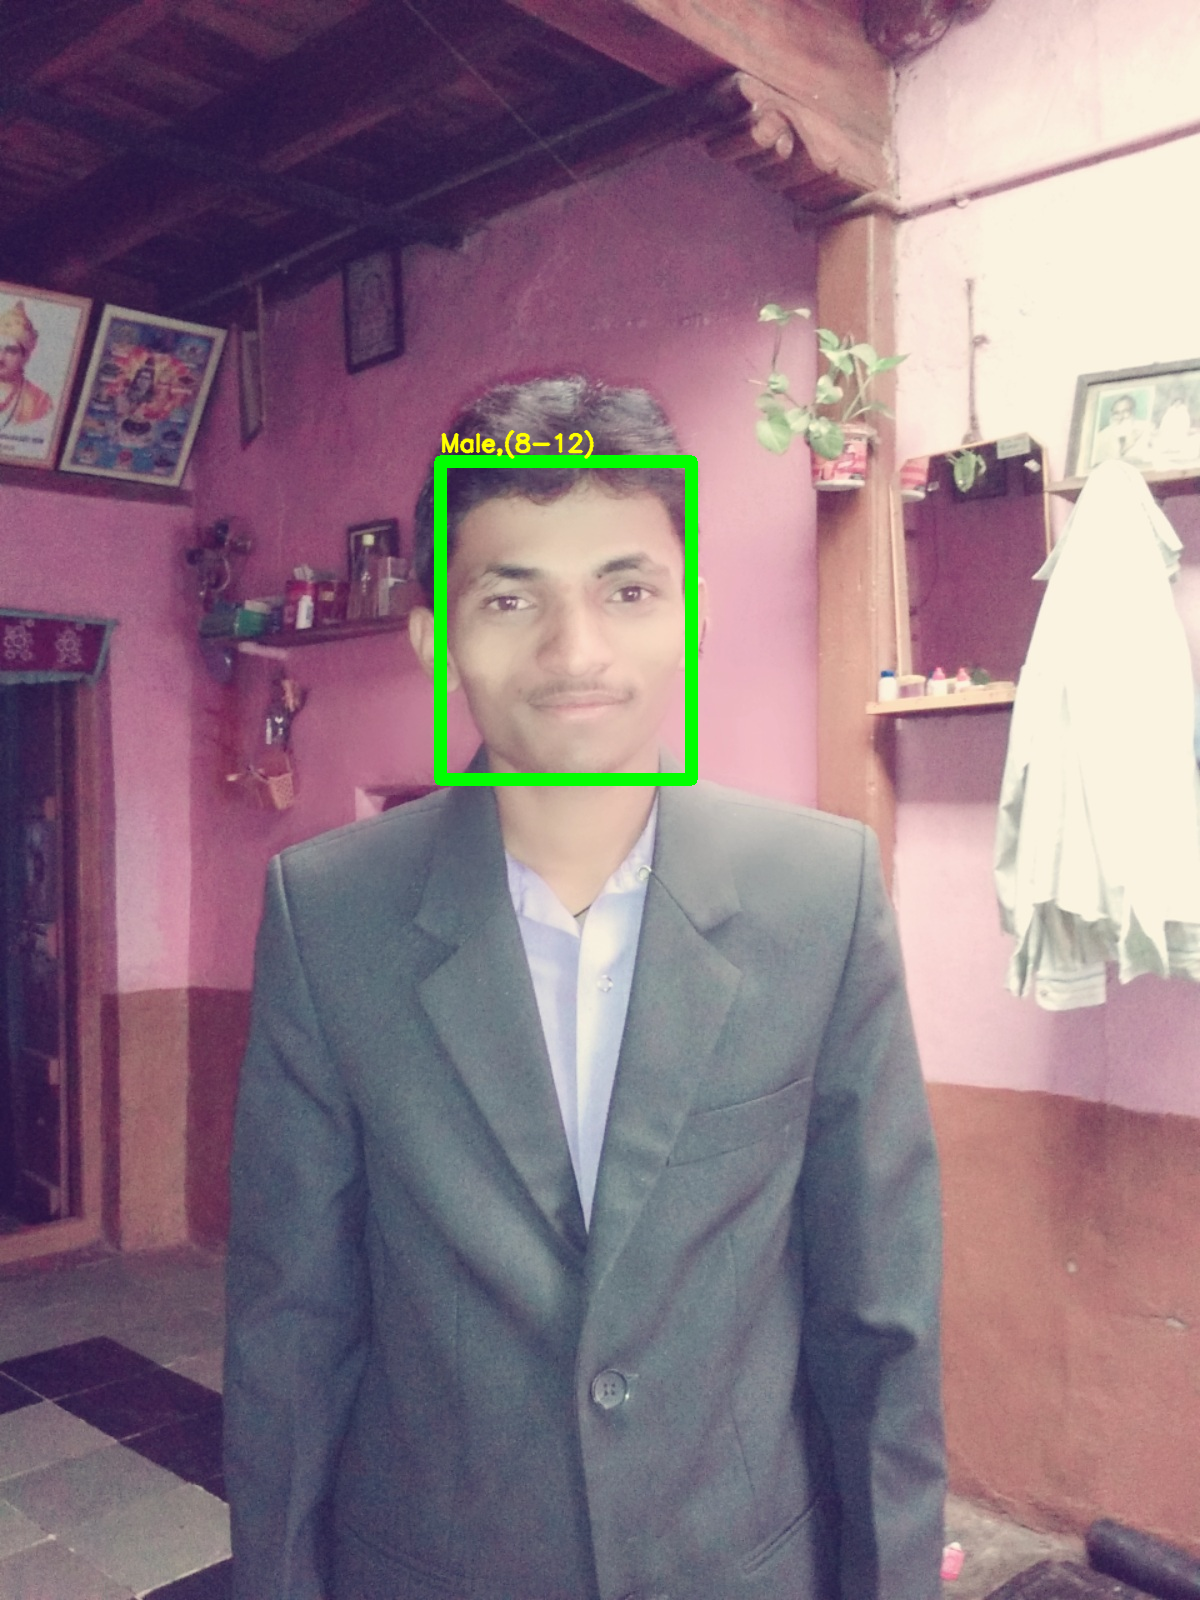

In [22]:
input = cv2.imread("img1.jpg")
output = age_gender_detector(input)
cv2_imshow(output)

(1280, 1204, 3)
Gender : Male, conf = 1.000
Age Output : [[7.4513487e-06 7.8538629e-05 1.3923375e-03 5.2379560e-01 4.6977597e-01
  4.8113246e-03 4.1413601e-05 9.7346063e-05]]
Age : (15-20), conf = 0.524
Gender : Male, conf = 0.606
Age Output : [[1.4028785e-01 8.4277374e-01 1.6407849e-02 9.5280993e-05 3.6661344e-04
  3.0275425e-05 2.5153295e-05 1.3318248e-05]]
Age : (4-6), conf = 0.843


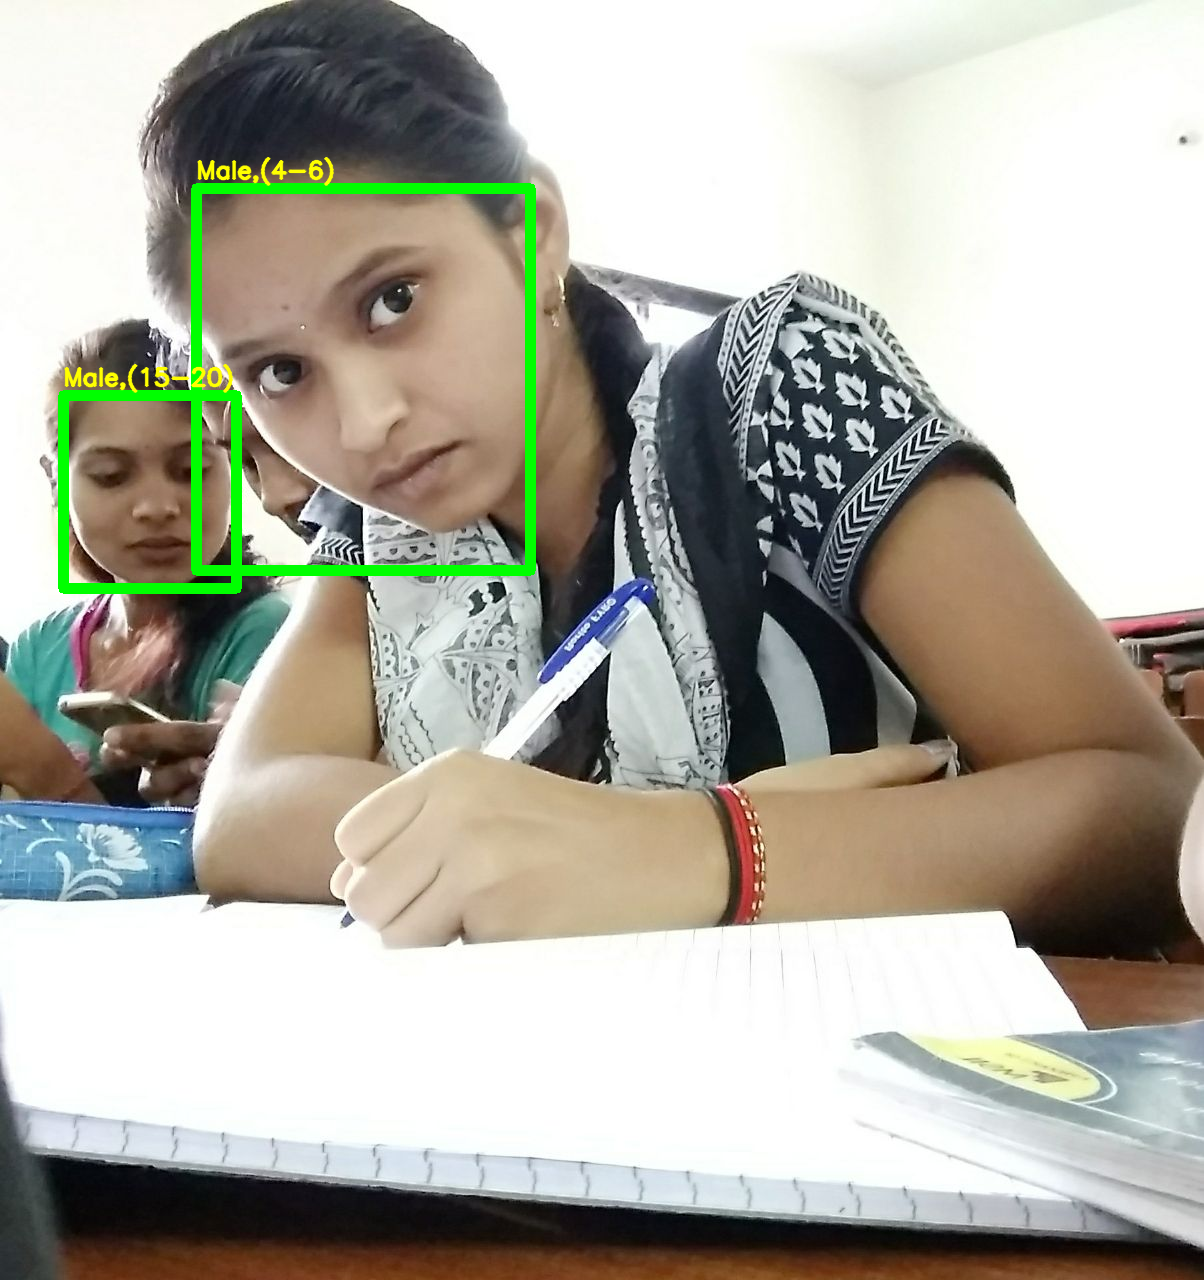

In [23]:
input = cv2.imread("img2.jpg")
output = age_gender_detector(input)
cv2_imshow(output)

(224, 224, 3)
Gender : Male, conf = 1.000
Age Output : [[0.02708933 0.00872765 0.27332646 0.01066134 0.21920414 0.04719552
  0.01281746 0.40097818]]
Age : (60-100), conf = 0.401


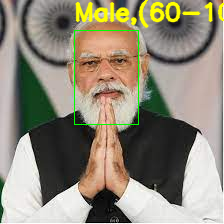

In [24]:
input = cv2.imread("namo.jpg")
output = age_gender_detector(input)
cv2_imshow(output)

(183, 276, 3)
Gender : Male, conf = 1.000
Age Output : [[9.9999678e-01 3.1779198e-06 2.9083811e-09 1.0776918e-12 2.4185384e-10
  8.8122429e-13 7.2569994e-13 4.0561183e-12]]
Age : (0-2), conf = 1.000


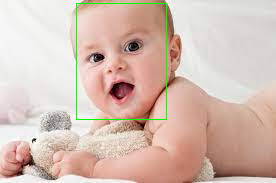

In [25]:
input = cv2.imread("baby1.jpg")
output = age_gender_detector(input)
cv2_imshow(output)

In [26]:
import cv2
cap = cv2.VideoCapture('video.mp4')
ret, frame = cap.read()
frame_height, frame_width, _ = frame.shape
out = cv2.VideoWriter('output.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 10, (frame_width,frame_height))
print("Processing Video...")
while cap.isOpened():
  ret, frame = cap.read()
  if not ret:
    out.release()
    break
  output = age_gender_detector(frame)
  out.write(output)
out.release()
print("Done processing video")

Processing Video...
(360, 397, 3)
Gender : Male, conf = 0.968
Age Output : [[0.00337304 0.0396006  0.00673789 0.03646049 0.83548975 0.04293573
  0.03312205 0.00228035]]
Age : (25-32), conf = 0.835
(360, 397, 3)
(360, 397, 3)
(360, 397, 3)
(360, 397, 3)
(360, 397, 3)
(360, 397, 3)
(360, 397, 3)
(360, 397, 3)
(360, 397, 3)
(360, 397, 3)
Gender : Male, conf = 1.000
Age Output : [[1.8411662e-06 2.3988676e-03 9.7540909e-01 2.1965332e-02 2.0888909e-04
  1.4142481e-05 5.0033157e-07 1.3373201e-06]]
Age : (8-12), conf = 0.975
(360, 397, 3)
Gender : Male, conf = 0.993
Age Output : [[2.6029772e-06 3.4790442e-04 4.5703894e-01 1.3530689e-01 4.0632173e-01
  8.9956465e-04 4.4795281e-05 3.7562539e-05]]
Age : (8-12), conf = 0.457
Gender : Female, conf = 0.995
Age Output : [[0.05963416 0.5303949  0.22712238 0.00231141 0.15920633 0.01390976
  0.00463224 0.00278871]]
Age : (4-6), conf = 0.530
(360, 397, 3)
Gender : Male, conf = 0.959
Age Output : [[1.4775659e-06 3.3653853e-04 1.2195408e-02 2.9434843e-03 9